<a href="https://colab.research.google.com/github/matheus-bokus/metodos_numericos/blob/master/Projeto_de_Interpola%C3%A7%C3%A3o_Curva_Caracter%C3%ADstica_LM35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
from numpy.polynomial import Polynomial as P
from numpy.linalg import solve
import cv2
from IPython.display import Image

# Definição da curva da resposta em Tensão do Sensor LM35


O Sensor de Temperatura LM35 é um sensor de precisão, que apresenta uma saída de tensão linear relativa à temperatura em que ele se encontrar no momento em que for alimentado por uma tensão de 4-20Vdc e GND, tendo em sua saída um sinal de 10mV para cada Grau Celsius de temperatura, sendo assim, apresenta uma boa vantagem com relação aos demais sensores de temperatura calibrados em “KELVIN”, não necessitando nenhuma subtração de variáveis para que se obtenha uma escala de temperatura em Graus Celsius.


<img src='/nbextensions/lm35.png'/>

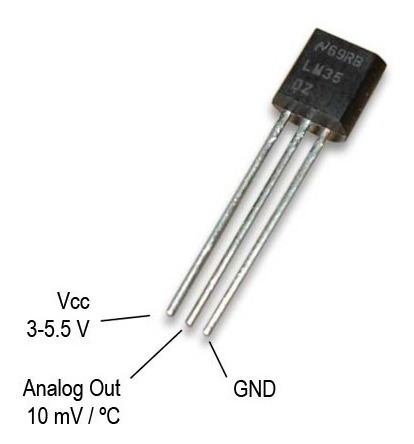

In [0]:
Image("/content/lm35.jpg", width=400, height=400)


O LM35 não necessita de qualquer calibração externa ou “trimming” para fornecer com exatidão, valores temperatura com variações de 0,25ºC ou até mesmo 0,75ºC dentro da faixa de temperatura de –55ºC à 150ºC. Este sensor tem saída com baixa impedância, tensão linear e calibração inerente precisa, fazendo com que o interfaceamento de leitura seja especificamente simples e o custo do sistema como um todo seja significantemente baixo. A saída é de 10mV/ºC. Ele drena apenas 60μA para estas alimentações, sendo assim seu auto-aquecimento é de aproximadamente 0.1ºC ao ar livre.

Especificações:
<ul>
<li> <a href="http://www.ti.com/lit/ds/symlink/lm35.pdf"> Sensor de Temperatura LM35 (datasheet)</a></li>
<li>Faixa de temperatura: -0°C a 100°C</li>
<li>Precisão: 0,5°C</li>
<li>Calibrado em graus Celsius</li>
<li>Tensão de operação: 4 a 30V</li>
<li>Consumo de corrente: 60 µA</li>
</ul>

Dessa forma, o sensor foi alimentedo com 5 Volts, e os dados obtidos, serão utilizados para a Interpolação, através de 4 metódos diferentes, a fim de verificar qual o melhor metódo para a verificação da curva de resposta do sensor.

##Dados

Os dados abaixo foram obtidos através da medição direta nos pinos do sensor, com um multímetro digital, e a temperatura, obtida através da medição realizada com um termômetro digital.

In [0]:
#Temperatura 
x=np.array([18.0882, 20.1067, 20.1969, 21.0106, 21.0443,22.3541,23.4602,
      23.9345, 27.0630, 28.2906,34.3205,35.4206, 35.4267,   36.99, 36.4478, 37.8453,39.9778])
#Tensão
y=np.array([0.180882, 0.201067, 0.201969, 0.210106, 0.210443, 0.223541,
       0.234602, 0.239345, 0.27063 , 0.282906,0.343205,0.354206, 0.354267,
        0.3699, 0.364478,0.378453,0.399778])
pd.DataFrame({"Temperatura":x,"Tensão medida em Ao":y})

,Temperatura,Tensão medida em Ao
0,18.0882,0.180882
1,20.1067,0.201067
2,20.1969,0.201969
3,21.0106,0.210106
4,21.0443,0.210443
5,22.3541,0.223541
6,23.4602,0.234602
7,23.9345,0.239345
8,27.0630,0.270630
9,28.2906,0.282906


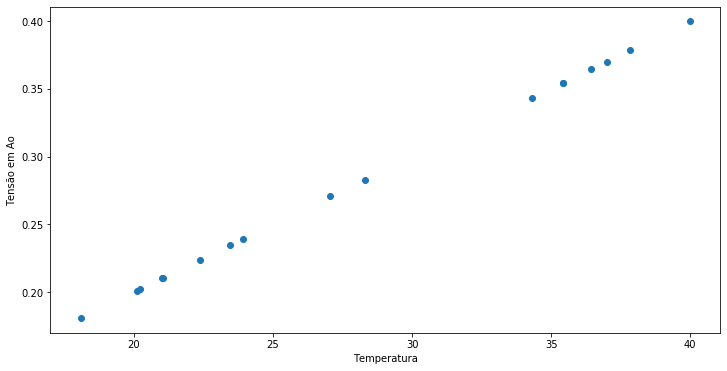

In [0]:
plt.figure(figsize=(12,6))
plt.plot(x,y,'o')
plt.xlabel('Temperatura')
plt.ylabel('Tensão em Ao')
plt.show()

In [0]:
dados=[]
dados=np.array(list(zip_longest(x,y)))
print(dados)

[[18.0882    0.180882]
 [20.1067    0.201067]
 [20.1969    0.201969]
 [21.0106    0.210106]
 [21.0443    0.210443]
 [22.3541    0.223541]
 [23.4602    0.234602]
 [23.9345    0.239345]
 [27.063     0.27063 ]
 [28.2906    0.282906]
 [34.3205    0.343205]
 [35.4206    0.354206]
 [35.4267    0.354267]
 [36.99      0.3699  ]
 [36.4478    0.364478]
 [37.8453    0.378453]
 [39.9778    0.399778]]


## Metódos

### Definição do Polinômio

Funções: 
* polin(ponto, polinômio): Recebe o polinômio e o ponto, e calcula seu valor no ponto dado;
* mostra_pol(polinômio): Recebe o polinômio e o exibe.

Todos os polinômios calculados estarão dentro do domìnio:

 $$ D = \{ x \in \mathscr{R} | 18.0882 \leq x \leq 39.9778  \} $$

In [0]:
def mostra_pol(coeficientes):
  funcao = list(coeficientes) 
  texto=""
  for i in range(len(funcao)):
    if funcao[i] == 0:
        continue
    elif i == 0:
        texto += str(funcao[i])
    else:
        texto += " + " + str(funcao[i])
        texto += ("*x^%o" % (i))
  return texto

In [0]:
def polin(p,Pln):
  print("Pn(%a) é igual a %a" % (p, Pln(p)))
  return Pln(p)

### Metódo Direto

Funcôes:

<ul>
<li><b> montamatriz(matriz,ordem)</b>: Recebe a matriz com os dados, e o número de colunas dessa matriz, e monta a matriz gaussiana, que na última coluna, recebe o vetor de valores de y, necessário para o calculo dos coeficientes, no formato:

$$matg = \begin{bmatrix}
        1 && x_0  && x_0^2 && ... && x_0^n && y_0
       \\
       1 && x_1  && x_1^2 && ... && x_1^n && y_1
       \\
       \vdots && \vdots && \vdots &&  &&  &&\vdots 
       \\
       1 && x_i  && x_i^2 && ... && x_i^n && y_i
      \end{bmatrix}
      $$  
Aonde x_i é o i-èsimo valor de x, e y_i de y, e n é a ordem do polinômio, definido como sendo o número de linhas da matriz de entrada-1. 

<li> <b>Gauss_esperto(matriz)</b>: Resolve o sistema Linear, de forma direta, recebendo a matriz dos dados, e realizando a pivotação e o escalonamento, e saparando a última da matriz, que corresponde aos valores de y, para resolver o sistema: 

$$ matg\ *\  A = Y  $$  


Aonde A é a matriz dos coeficientes, e Y a matriz dos Valores do polinômio a ser definido. \\
Retorna um vetor com os coeficientes no formato:

$$A=[a_0,a_1,..., a_n]$$  
</ul>

In [0]:
def montamatriz(ab,ord):
  mg=np.copy(ab)
  n=ord
  a=0
  matg=np.zeros((n,n+1))
  for i in range(n):
    a=mg[i,0]
    for y in range(n):
      matg[i,y]=a**y
    matg[i,-1]=mg[i,-1]
  return matg

In [0]:
def gauss_esperto(A):#método que fará o escalonamento  
    A4=np.copy(A)
    A5=montamatriz(A4,A4.shape[0])
    n1=int(A5.shape[0])
    c=np.argmax(np.abs(A5[:,0]))#recebe o indice da linha com o maior termo absoluto
    A5[[0,c]]=A5[[c,0]]
    for k in range(len(A5)):
        for i in range(k+1,n1):#i está sempre 1 unidade a frente de k, já q i=k+1
          m=A5[i][k]/A5[k][k]#m=-valor/pivo
          A5[i] = A5[i] - m * A5[k]# aqui ele faz a multiplicação de toda a linha i pelo fator m achado anteriormente
    b = np.empty([n1])
    for i in range(n1):
      b[i]=A5[i][n1]#Seleciona os termos independentes
    # Resolver sistema Ax = b
    for i in range(1, n1):#x[i]
      # definir vetor (solucao) x
      rt = np.empty([n1])
      rt[n1 - 1] = b[n1 - 1] / A5[n1 - 1][n1 - 1]#x=b/a
      for i in range(n1 - 2, -1, -1):#penúltimo ao último
        soma = 0
        for j in range(i + 1, n1):
           soma += A5[i][j] * rt[j]#Somatório dos termos anteriores

        rt[i] = (b[i] - soma) / A5[i][i]#x=(b-somatório dos termos anteriores)/a 
    return rt

In [0]:
pd.DataFrame(montamatriz(dados,dados.shape[0])[:,:-1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,18.0882,327.182979,5918.151165,1.070487e+05,1.936318e+06,3.502451e+07,6.335304e+08,1.145942e+10,2.072804e+11,3.749329e+12,6.781861e+13,1.226717e+15,2.218909e+16,4.013608e+17,7.259894e+18,1.313184e+20
1,1.0,20.1067,404.279385,8128.724308,1.634418e+05,3.286276e+06,6.607616e+07,1.328574e+09,2.671323e+10,5.371149e+11,1.079961e+13,2.171445e+14,4.366059e+15,8.778703e+16,1.765108e+18,3.549049e+19,7.135966e+20
2,1.0,20.1969,407.914770,8238.613810,1.663945e+05,3.360652e+06,6.787476e+07,1.370860e+09,2.768712e+10,5.591939e+11,1.129398e+13,2.281035e+14,4.606983e+15,9.304677e+16,1.879256e+18,3.795515e+19,7.665764e+20
3,1.0,21.0106,441.445312,9275.030880,1.948740e+05,4.094419e+06,8.602620e+07,1.807462e+09,3.797586e+10,7.978956e+11,1.676427e+13,3.522273e+14,7.400507e+15,1.554891e+17,3.266919e+18,6.863993e+19,1.442166e+21
4,1.0,21.0443,442.862562,9319.732624,1.961272e+05,4.127361e+06,8.685742e+07,1.827854e+09,3.846590e+10,8.094879e+11,1.703511e+13,3.584919e+14,7.544211e+15,1.587626e+17,3.341049e+18,7.031003e+19,1.479625e+21
5,1.0,22.3541,499.705787,11170.473129,2.497059e+05,5.581950e+06,1.247795e+08,2.789333e+09,6.235302e+10,1.393846e+12,3.115817e+13,6.965128e+14,1.556992e+16,3.480515e+17,7.780377e+18,1.739233e+20,3.887900e+21
6,1.0,23.4602,550.380984,12912.047962,3.029192e+05,7.106546e+06,1.667210e+08,3.911308e+09,9.176006e+10,2.152709e+12,5.050299e+13,1.184810e+15,2.779589e+16,6.520970e+17,1.529833e+19,3.589018e+20,8.419908e+21
7,1.0,23.9345,572.860290,13711.124617,3.281689e+05,7.854559e+06,1.879949e+08,4.499565e+09,1.076948e+11,2.577622e+12,6.169409e+13,1.476617e+15,3.534210e+16,8.458954e+17,2.024608e+19,4.845799e+20,1.159818e+22
8,1.0,27.0630,732.405969,19821.102739,5.364185e+05,1.451709e+07,3.928761e+08,1.063241e+10,2.877448e+11,7.787238e+12,2.107460e+14,5.703419e+15,1.543516e+17,4.177218e+18,1.130481e+20,3.059420e+21,8.279708e+22
9,1.0,28.2906,800.358048,22642.609403,6.405730e+05,1.812219e+07,5.126878e+08,1.450424e+10,4.103338e+11,1.160859e+13,3.284139e+14,9.291027e+15,2.628487e+17,7.436149e+18,2.103731e+20,5.951581e+21,1.683738e+23


In [0]:
polnt=gauss_esperto(dados)

In [0]:
gauss=[polin(valorg,P(polnt)) for valorg in dados[:,0]]

Pn(18.0882) é igual a 0.18088200000000001
Pn(20.1067) é igual a 0.20106700000000002
Pn(20.1969) é igual a 0.20196900000000004
Pn(21.0106) é igual a 0.21010600000000001
Pn(21.0443) é igual a 0.21044300000000002
Pn(22.3541) é igual a 0.22354100000000005
Pn(23.4602) é igual a 0.23460200000000006
Pn(23.9345) é igual a 0.23934500000000003
Pn(27.063) é igual a 0.27063000000000004
Pn(28.2906) é igual a 0.282906
Pn(34.3205) é igual a 0.34320499999999987
Pn(35.4206) é igual a 0.35420600000000013
Pn(35.4267) é igual a 0.3542669999999999
Pn(36.99) é igual a 0.3699000000000001
Pn(36.4478) é igual a 0.3644780000000001
Pn(37.8453) é igual a 0.37845300000000004
Pn(39.9778) é igual a 0.39977799999999886


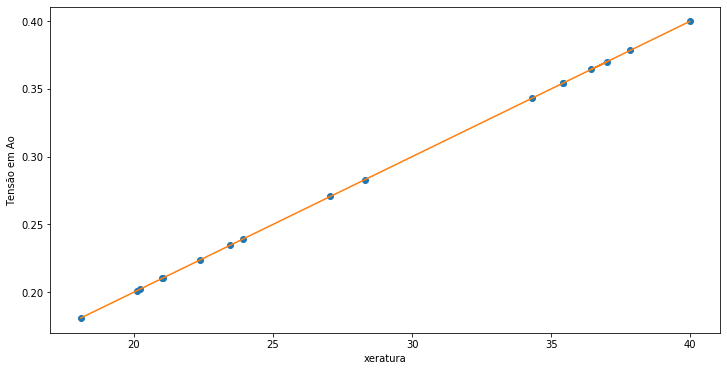

In [0]:
plt.figure(figsize=(12,6))
plt.plot(x,y,'o',dados[:,0],gauss,'-')
plt.xlabel('xeratura')
plt.ylabel('Tensão em Ao')
plt.show()


### Metódo de Newton

Funcôes: 

<ul> 
<li> <b>int_newton(matriz)</b> : Recebe a matriz dos dados, e retorna os coeficientes do Polinômio de Newton, por meio da forma prática:

$$f[x_i, x_j] = \frac{f(x_i) - f(x_j)}{x_i - x_j}$$
Logo:

$$ b_n=f[x_n, x_{n-1}, \ldots, x_2, x_1] = \frac{f[x_n, x_{n-1}, \ldots, x_2] - f[x_{n-1}, \ldots, x_2, x_1]}{x_n - x_1} $$
e monta o polinômio no formato :
$$P_n(x)= b_0+b_1(x-x_0)+...+ b_n(x-x_{n-1})$$

</ul>  




In [0]:
def int_newton(p_newton):
  pontos=[]
  pontos=np.copy(p_newton)
  l = []
  for i in range(len(pontos)):
      l.append(pontos[i][1])
  tabela = []  # Será a tabela de diferenças divididas
  tabela.append(l)
  # Calcula as diferenças divididas
  # o polinômio a+bX+cX^2 eu tenho que escrever P([a,b,c]), logo P([1,2,3...n]) = 1+2x+3x^2+....nx^(n-1)
  for i in range(len(pontos) - 1):
      l = []  # lista que irá receber as diferenças divididas de ordem i+1
      for j in range(len(pontos) - i - 1):
          # calculando a j+1 difença dividida de ordem i+1
          dif = (tabela[i][j + 1] - tabela[i][j]) / (pontos[j + 1 + i][0] - pontos[j][0])
          l.append(dif)
      tabela.append(l)  # adiciona a tabela de diferenças divididas as difenças divididas de ordem i+1
  difdiv = []  # irei pegar a primeira diferença dividida de cada ordem e adicionar a essa lista,
  # pois elas corresponderão a d0, d1... dn do polinômio como na fórmula
  for i in range(len(tabela)):
      difdiv.append(tabela[i][0])
  # Aqui será feito o Somatório 
  somatorio = 0
  for i in range(1, len(pontos)):
      produtorio = 1
      for k in range(i):  # Aqui será feito o produtório 
          produtorio *= (P([-pontos[k][0], 1]))  # P([-pontos[k][0], 1]) = (X-Xk)
      somatorio += difdiv[i] * produtorio
  Pn1 = difdiv[0] + somatorio
  funcaon = list(Pn1)  # tranformo o polinômio em lista
  # transformando o polinômio para uma formato mais legível
  return Pn1

In [0]:
poln=int_newton(dados)

In [0]:
mostra_pol(poln)

'0.0002901712652895183 + 0.009825607118417056*x^1 + 4.891871836655927e-05*x^2 + -8.501396778899422e-06*x^3 + 1.0244699246138696e-06*x^4 + -9.077119655121795e-08*x^5 + 6.116955240029025e-09*x^6 + -3.198075990709578e-10*x^7 + 1.3109841938990683e-11*x^10 + -4.2277192858221644e-13*x^11 + 1.0689869669069956e-14*x^12 + -2.0970547315564975e-16*x^13 + 3.1289097104657367e-18*x^14 + -3.4326274401027085e-20*x^15 + 2.6113661465634417e-22*x^16 + -1.2308219953606281e-24*x^17 + 2.707798885099115e-27*x^20'

In [0]:
respn=[polin(valorn,poln) for valorn in dados[:,0]]

Pn(18.0882) é igual a 0.18088200000000013
Pn(20.1067) é igual a 0.20106700000000016
Pn(20.1969) é igual a 0.20196900000000015
Pn(21.0106) é igual a 0.21010600000000018
Pn(21.0443) é igual a 0.2104430000000002
Pn(22.3541) é igual a 0.22354100000000027
Pn(23.4602) é igual a 0.2346020000000005
Pn(23.9345) é igual a 0.23934500000000028
Pn(27.063) é igual a 0.2706300000000005
Pn(28.2906) é igual a 0.2829060000000013
Pn(34.3205) é igual a 0.3432050000000071
Pn(35.4206) é igual a 0.35420600000000524
Pn(35.4267) é igual a 0.35426700000000266
Pn(36.99) é igual a 0.369900000000002
Pn(36.4478) é igual a 0.3644780000000092
Pn(37.8453) é igual a 0.3784530000000159
Pn(39.9778) é igual a 0.3997780000000187


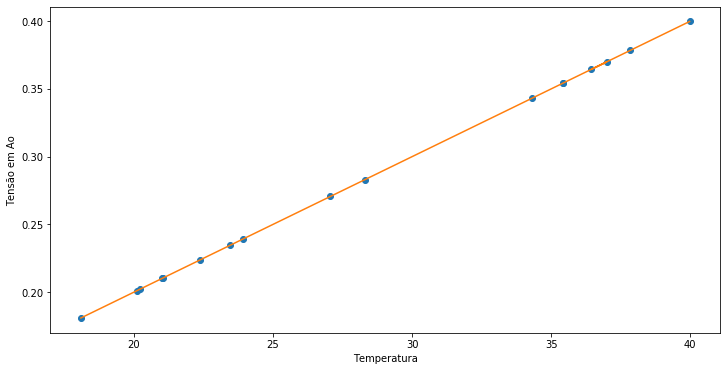

In [0]:
plt.figure(figsize=(12,6))
plt.plot(x,y,'o',dados[:,0],respn,'-')
plt.xlabel('Temperatura')
plt.ylabel('Tensão em Ao')
plt.show()

### Metódo de Lagrange

Funcôes:

<ul> 
<li> <b>int_lagrange(matriz)</b>: Recebe a matriz dos dados. e calcula o coeficiente de Lagrange. no formato:

$$L_i(x) = \prod_{j=1\\j \neq k}^n \frac{x-x_j}{x_i-x_j}$$

Depois, o polinômio de Lagrange é montado como sendo:

$$f_{n-1} = \sum_{k=1}^n L_i(x)f(x_i)$$
</ul>

In [0]:
def int_lag(pontosl):
  pontos=np.copy(pontosl)
  Pn2 = 0
  for k in range(len(pontos)):
      numerador = P([1])
      denominador = P([1])
      for j in range(len(pontos)):  # calculando o numerador e o denominador do produtório
          if j == k:  #Exclui os casos em que j=k
              continue
          numerador *= P([-pontos[j][0], 1])  
          denominador *= pontos[k][0] - pontos[j][0]  
      Pn2 = Pn2 + pontos[k][1] * (numerador // denominador)  # Realiza o somatório
  funcaol = list(Pn2)  # Muda o polinômio para lista
  return Pn2

In [0]:
poll=int_lag(dados)
respl=[polin(valorl,poll) for valorl in dados[:,0]]

Pn(18.0882) é igual a -0.31047547074264314
Pn(20.1067) é igual a -0.637177467649432
Pn(20.1969) é igual a -0.6569560659424615
Pn(21.0106) é igual a -0.8639134032008704
Pn(21.0443) é igual a -0.8737342363712809
Pn(22.3541) é igual a -1.3577479677509963
Pn(23.4602) é igual a -1.9821396351959075
Pn(23.9345) é igual a -2.3366620579430792
Pn(27.063) é igual a -7.102356078639476
Pn(28.2906) é igual a -11.025934228829302
Pn(34.3205) é igual a -86.34806792130762
Pn(35.4206) é igual a -122.37500493490501
Pn(35.4267) é igual a -122.60880505141716
Pn(36.99) é igual a -198.1920074389524
Pn(36.4478) é igual a -168.11946344379663
Pn(37.8453) é igual a -255.8511743028386
Pn(39.9778) é igual a -473.22669358744866


In [0]:
mostra_pol(poll)

'0.000677027739584446 + 0.00891589093953371*x^1 + 0.0001824364298954606*x^2 + -2.0099658286198974e-05*x^3 + 3.0445517040789127e-06*x^4 + -8.088529739325168e-07*x^5 + 3.6406632375474146e-08*x^6 + -1.335077826070119e-09*x^7 + 6.654060635824521e-11*x^10 + -1.571371505137975e-12*x^11 + 6.747505115409225e-15*x^12 + -1.0467963505018073e-15*x^13 + 8.82921997927261e-18*x^14 + -1.7426172605624006e-19*x^15 + -6.493739393582063e-22*x^16 + -9.697498662318107e-25*x^17 + 1.2448052521064549e-26*x^20'

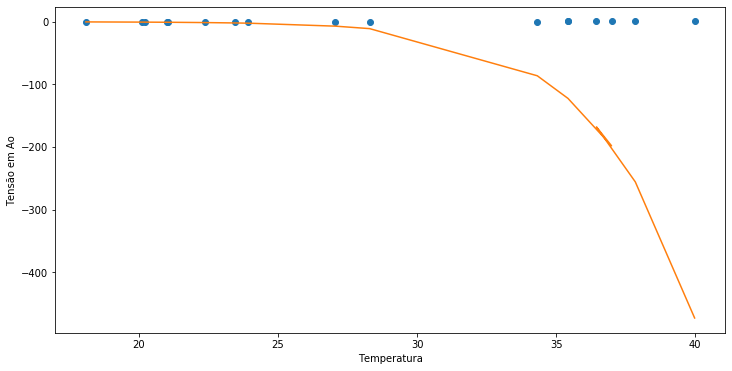

In [0]:
plt.figure(figsize=(12,6))
plt.plot(x,y,'o',dados[:,0],respl,'-')
plt.xlabel('Temperatura')
plt.ylabel('Tensão em Ao')
plt.show()

### Spline Quadrática

Dividindo os intervalo da interpolação em 9 subintervalos, obtidos através de 10 pontos, foram obtidas as seguintes equações quadráticas:

$$
a_1 x^2+b_1 x+c_1,	    18.08 <= x <= 20.19  \\
a_2x^2+b_2 x+c_2, 		  20.19 <= x <= 21.04  \\
a_3*x^2+b_3 x+c_3, 	    21.04 <= x <= 23.46  \\
a_4x^2+b_4 x+c_4, 	    23.46 <= x <= 27.06  \\
a_5x^2+b_5 x+c_5,    	  7.06 <= x <= 34.32  \\
a_6x^2+b_6 x+c_6, 		  34.32 <= x <= 35.42  \\
a_8 x^2+b_7 x+c_7, 	    35.42 <= x <= 36.44  \\
a_8 x^2+b_8 x+c_8, 		  36.44 <= x <= 37.84  \\
a_9 x^2+b_9 x+c_9, 	    37.84 <= x <= 39.97
$$

Dessa forma, os coeficientes foram encontrados resolvendo o sistema linear:

$$ X *\  A = Y  $$  

Aonde é a matriz dos coeficientes, X é a matriz das entradas, e Y a matriz da sáidas.

Funções:

<ul>

<li> <b> matspline() </b> : Retorna os coeficientes dos polinônimios da Spline quadrática, e a matriz de entradas, necessária para encontrar o intervalo ao qual o ponto pertence. 
O retorno é no formato:
$$A=[a_1,..., a_9, b_1,..., c_1,..., c_9]$$
<li> <b>pol_spline(ponto)</b>: Utiliza a função Polynomial para montar a equação quadrática, com os coeficientes adequados, definidos pelos intervalos, e encontra o valor da função no ponto.

<li><b>mostra_intervalos</b>: Mostra os polinômios definidos para cada intervalo.
</ul>

In [0]:
#10 pontos
def matspline():
  matspline1=np.zeros([26,26],dtype=float)
  yspline=np.array([0.1808,0.2019,0.2019,0.2104,0.2104,0.2346,0.2346,0.2706,0.2706,0.3432,0.3432,0.3542,0.3542,0.3644,0.3644,0.3784,0.3784,0.3997,0,0,0,0,0,0,0,0,0])
  x=np.array([18.08,20.19,21.04,23.46,27.06,34.32,35.42,36.44,37.84,39.97])
  matspline1=[[
  # a1      a2    a3    a4    a5    a6    a7    a8    a9    b1    b2    b3    b4    b5    b6    b7    b8    b9    c1    c2    c3    c4    c5    c6    c7    c8    c9
    x[0]**2,0 ,   0,    0,    0,    0,    0,    0,    0,    x[0], 0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
   [x[1]**2,0 ,   0,    0,    0,    0,    0,    0,    0,    x[1], 0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
    [0,   x[1]**2,0,    0,    0,    0,    0,    0,    0,    0,   x[1],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0],
    [0,   x[2]**2,0,    0,    0,    0,    0,    0,    0,    0,   x[2],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0],
    [0,   0,    x[2]**2,0,    0,    0,    0,    0,    0,    0,   0,    x[2],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0],
    [0,   0,    x[3]**2,0,    0,    0,    0,    0,    0,    0,   0,    x[3],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0],
    [0,   0,     0,   x[3]**2,0,    0,    0,    0,    0,    0,   0,     0,   x[3],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
    [0,   0,     0,   x[4]**2,0,    0,    0,    0,    0,    0,   0,     0,   x[4],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
    [0,   0,     0,     0, x[4]**2, 0,    0,    0,    0,    0,   0,     0,    0,   x[4],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
    [0,   0,     0,     0, x[5]**2, 0,    0,    0,    0,    0,   0,     0,    0,   x[5],  0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
    [0,   0,     0,     0,    0, x[5]**2, 0,    0,    0,    0,   0,     0,    0,    0,  x[5],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0],
    [0,   0,     0,     0,    0, x[6]**2, 0,    0,    0,    0,   0,     0,    0,    0,  x[6],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0],
    [0,   0,     0,     0,    0,    0,  x[6]**2,0,    0,    0,   0,     0,    0,    0,    0,  x[6],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0],
    [0,   0,     0,     0,    0,    0,   x[7]**2,0,   0,    0,   0,     0,    0,    0,    0,  x[7],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0],    
    [0,   0,     0,     0,    0,    0,    0, x[7]**2, 0,    0,   0,     0,    0,    0,    0,    0,  x[7],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0],    
    [0,   0,     0,     0,    0,    0,    0, x[8]**2, 0,    0,   0,     0,    0,    0,    0,    0,  x[8],   0,    0,    0,    0,    0,    0,    0,    0,    1,    0],    
    [0,   0,     0,     0,    0,    0,    0,   0,  x[8]**2, 0,   0,     0,    0,    0,    0,    0,    0,  x[8],   0,    0,    0,    0,    0,    0,    0,    0,    1],    
    [0,   0,     0,     0,    0,    0,    0,   0,  x[9]**2, 0,   0,     0,    0,    0,    0,    0,    0,  x[9],   0,    0,    0,    0,    0,    0,    0,    0,    1],  
[2*x[1],-2*x[1], 0,     0,    0,    0,    0,   0,     0,    1,  -1,     0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],  
   [0,   2*x[2],-2*x[2],0,    0,    0,    0,   0,     0,    0,   1,    -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0], 
   [0,    0,   2*x[3],-2*x[3],0,    0,    0,   0,     0,    0,   0,     1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [0,    0,    0,   2*x[4],-2*x[4],0,    0,   0,     0,    0,   0,     0,    1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [0,    0,    0,      0,2*x[5],-2*x[5], 0,   0,     0,    0,   0,     0,    0,    1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [0,    0,    0,      0,    0,2*x[6],-2*x[6],0,     0,    0,   0,     0,    0,    0,    1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [0,    0,    0,      0,    0,   0, 2*x[7],-2*x[7], 0,    0,   0,     0,    0,    0,    0,    1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [0,    0,    0,      0,    0,   0,     0,2*x[8],-2*x[8], 0,   0,     0,    0,    0,    0,    0,    1,   -1,    0,    0,    0,    0,    0,    0,    0,    0,    0],   
   [1,    0,    0,      0,    0,   0,     0,   0,     0,    0,   0,     0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]             
 
  return  x,solve(matspline1,yspline)

In [0]:
def pol_spline(xi):
  mat,coef= matspline()
  global spline_pol
  if xi>=mat[0] and xi<=mat[1]: 
    spline_pol=P([coef[0],coef[9],coef[18]])
  if xi>mat[1] and xi<=mat[2]: 
    spline_pol=P([coef[1],coef[10],coef[19]])
  if xi>mat[2] and xi<=mat[3]:
   spline_pol= P([coef[2],coef[11],coef[20]])
  if xi>mat[3] and xi<=mat[4]: 
    spline_pol=P([coef[3],coef[12],coef[21]])
  if xi>mat[4] and xi<=mat[5]: 
    spline_pol=P([coef[4],coef[13],coef[22]])
  if xi>mat[5] and xi<=mat[6]: 
    spline_pol=P([coef[5],coef[14],coef[23]])
  if xi>mat[6] and xi<=mat[7]: 
    spline_pol=P([coef[6],coef[15],coef[24]])
  if xi>mat[7] and xi<=mat[8]: 
    spline_pol=P([coef[7],coef[16],coef[25]])
  if xi>mat[8] and xi<=mat[9]: 
    spline_pol=P([coef[8],coef[17],coef[26]])
  
  return spline_pol(xi)

In [0]:
 def mostra_intervalos():
  mat1,coef1= matspline()
  for i in range(int(len(coef1)/3)):
    print('{:.2f}* x^2+{:.2f}*x+{:.2f}, \t\t {:.2f} <= x <= {:.2f}'.format(coef1[i],coef1[i+9],coef1[i+18],mat1[i],mat1[i+1]))
  return

In [0]:
mostra_intervalos()

In [0]:
spl=[pol_spline(valor) for valor in dados[:,0]]
spl

In [0]:
plt.figure(figsize=(12,6))
plt.plot(x,y,'o',dados[:,0],spl,'-')
plt.xlabel('Temperatura')
plt.ylabel('Tensão em Ao')
plt.show()

## Comparação entre os Metódos

In [0]:
x=dados[:,0]
fig, axe = plt.subplots(2, 2,figsize=(15,10))
axe[0, 0].plot(x, gauss)
axe[0, 0].set_title('Método Direto',color="w")
axe[0, 1].plot(x, respn, 'tab:orange')
axe[0, 1].set_title('Metódo de Newton',color="w")
axe[1, 1].plot(x, respl, 'tab:green')
axe[1, 1].set_title('Metódo de Lagrange',color="w")
axe[1, 0].plot(x, spl, 'tab:red')
axe[1, 0].set_title('Metódo da Spline Quadrática',color="w")
plt.rcParams.update({"ytick.color" : "w","xtick.color" : "w"})

for ax in axe.flat:
    ax.set(xlabel='Temperatura(ºC)', ylabel='Tensão Medida(V)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axe.flat:
    ax.label_outer()

Como é possível perceber, por ser um polinômio de 1º, todos os metódos, exceto lagrange, conseguiram encontrar a reta de maneira satisfatória, sendo o metódo Spline o que mais se aproxima dos valores reais obtidos por medição

Também é percetível que o metódo de lagrange não obteve o polinômio desejado, devido a ser um polinômio de grau pequeno, cujo metódo não se torna tão eficaz.

## Referências


Sensor de Temperatura LM35DZ. Disnonível em https://www.filipeflop.com/produto/sensor-de-temperatura-lm35dz/. Acesso 05/12/2019

Sensor de Temperatura LM35 - Original Texas Instruments. Disponível em: https://www.baudaeletronica.com.br/sensor-de-temperatura-lm35.html. Acesso 05/12/2019